# Example using some utility functions

Imaging matching only requires 3 functions to run effectively.  

1. Interpolation
1. FFT
1. Gradient

We demonstrate each of them here.

## Library imports
We start by importing necessary libraries.  That includes numpy, matplotlib, and tensorflow for numerical work, nibabel for loading neuroimages, and lddmm and vis which are part of this library.

In [1]:
import numpy as np # for arrays
%matplotlib notebook
import matplotlib as mpl # for graphics
import matplotlib.pyplot as plt
import nibabel as nib # for loading neuroimages
import tensorflow as tf
import lddmm # algorithm
import vis # visualization


importing vis


## Example data
We will use some human MRI as example data.  This is an atlas from mricloud.org.

In [2]:
# the filename
image_fname = 'Adt27-55_02_Adt27-55_02_MNI.img'
# load the image
img = nib.load(image_fname)
# get the number of voxels and the spacing
nx = img.header['dim'][1:4]
dx = img.header['pixdim'][1:4]
# get the location of each voxel
x = [np.arange(nxi)*dxi - np.mean(np.arange(nxi)*dxi) for nxi,dxi in zip(nx,dx)]
# get the image, note that it includes a fourth axis for time that we don't want
I = img.get_data()[:,:,:,0]

## Visualization
We visualize our image using the functions included in the vis module

<IPython.core.display.Javascript object>


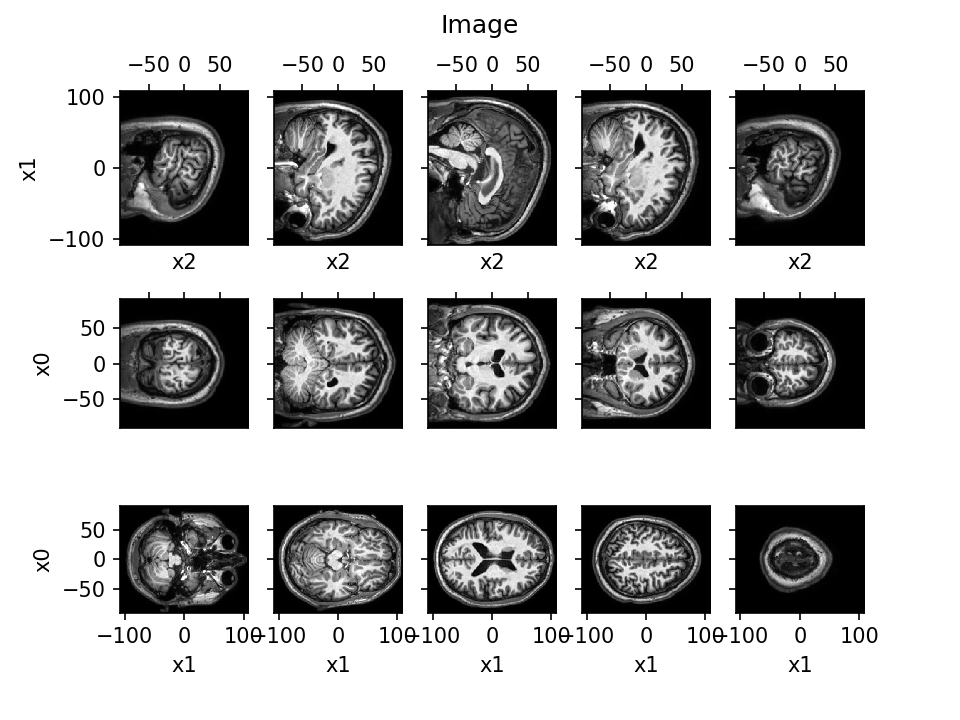

In [3]:
f = plt.figure()
vis.imshow_slices(I,x=x,fig=f)
f.suptitle('Image')
f.canvas.draw()

## Interpolation
Deformations are computed by interpolating an image at a set of points.  We demonstrate interpolation here:

<IPython.core.display.Javascript object>


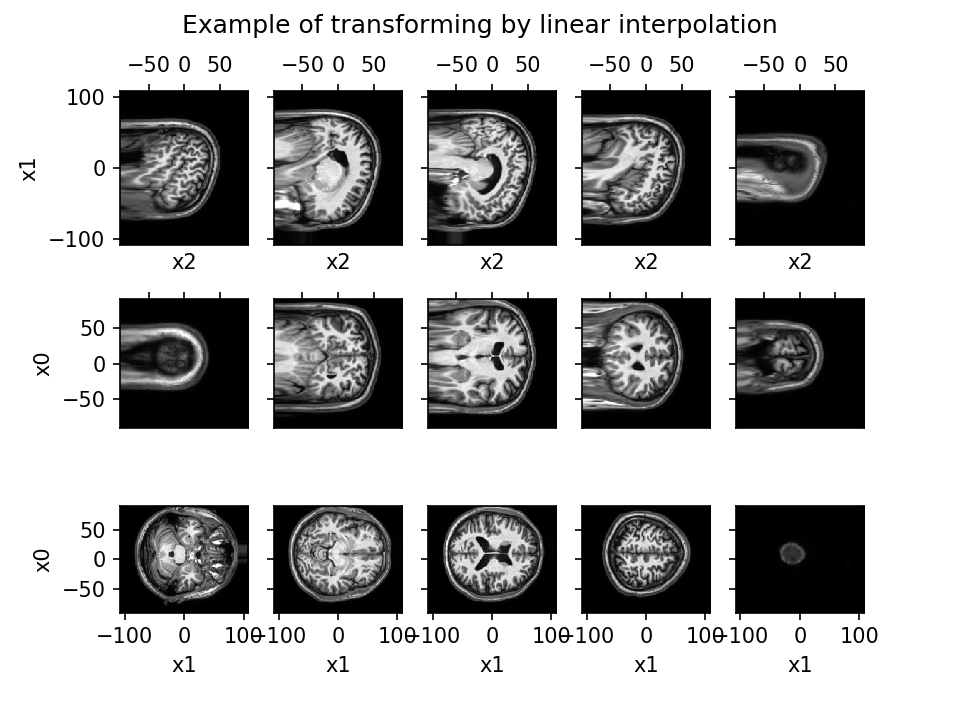

In [4]:
X0,X1,X2 = np.meshgrid(x[0],x[1],x[2],indexing='ij')
X0tf = tf.constant(X0,dtype=lddmm.dtype)
X1tf = tf.constant(X1,dtype=lddmm.dtype)
X2tf = tf.constant(X2,dtype=lddmm.dtype)
Itf = tf.constant(I,dtype=lddmm.dtype)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    Id = lddmm.interp3(x[0],x[1],x[2],Itf,X0tf+10,X1tf*1.2,X2tf + X2tf**2*0.005)
    Idnp = Id.eval()
f = plt.figure()
vis.imshow_slices(Idnp,x=x,fig=f)
f.suptitle('Example of transforming by linear interpolation')
f.canvas.draw()


<IPython.core.display.Javascript object>


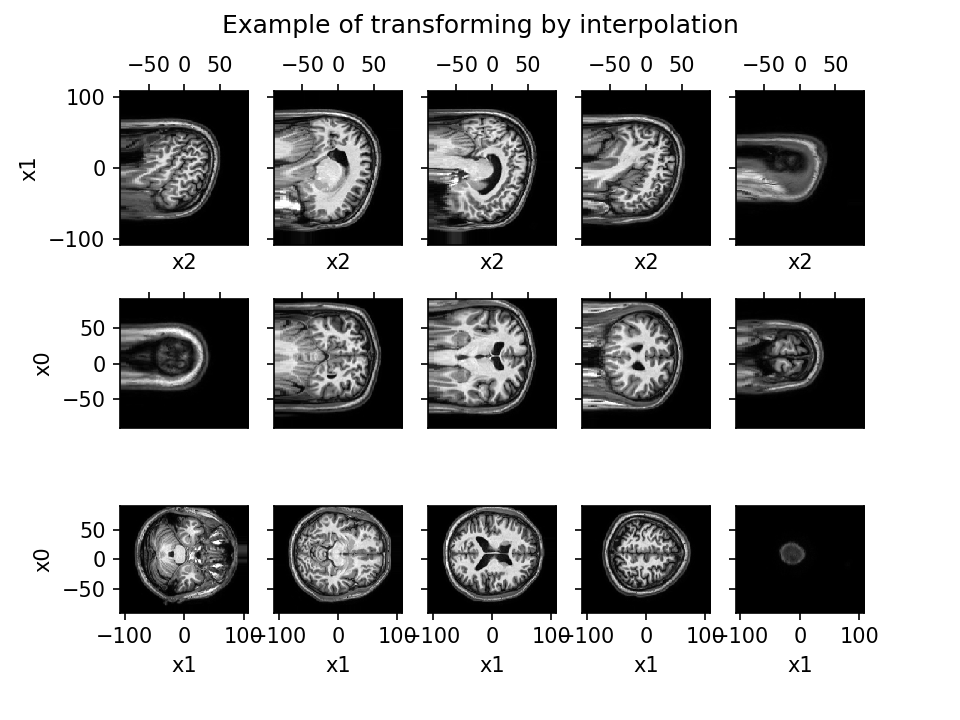

In [5]:
X0,X1,X2 = np.meshgrid(x[0],x[1],x[2],indexing='ij')
X0tf = tf.constant(X0,dtype=lddmm.dtype)
X1tf = tf.constant(X1,dtype=lddmm.dtype)
X2tf = tf.constant(X2,dtype=lddmm.dtype)
Itf = tf.constant(I,dtype=lddmm.dtype)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    Id = lddmm.interp3(x[0],x[1],x[2],Itf,X0tf+10,X1tf*1.2,X2tf + X2tf**2*0.005, method=0)
    Idnp = Id.eval()
f = plt.figure()
vis.imshow_slices(Idnp,x=x,fig=f)
f.suptitle('Example of transforming by nearest neighbor interpolation')
f.canvas.draw()


## Gradient
Gradients are required to know how the energy will change when the image moves a small amount.  We demonstrate this here

<IPython.core.display.Javascript object>


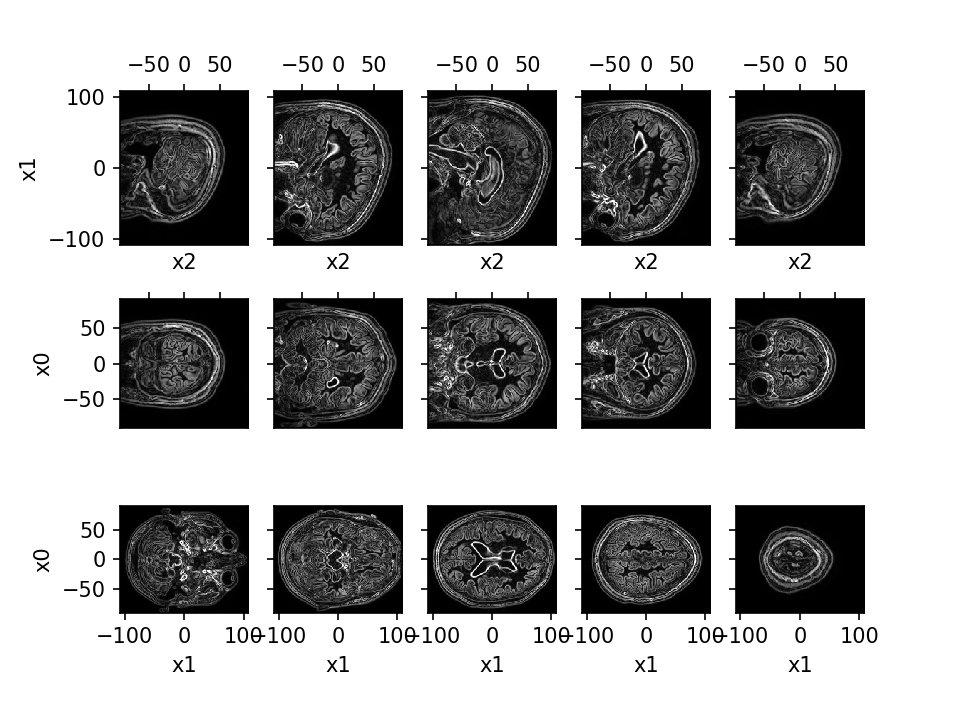

In [6]:
Itf = tf.constant(I,dtype=lddmm.dtype)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # calculate the gradient
    I_0,I_1,I_2 = lddmm.grad3(Itf,dx)
    # calculate its norm
    Ishow = tf.sqrt(I_0**2 + I_1**2 + I_2**2)
    # get data from tensorflow graph into numpy array
    Ishownp = Ishow.eval()
f = plt.figure()        
vis.imshow_slices(Ishownp,x=x,fig=f)
f.canvas.draw()


## FFTs
FFTs are used to implement convolutions, which are required to work with smooth functions needed for diffeomorphisms.

<IPython.core.display.Javascript object>


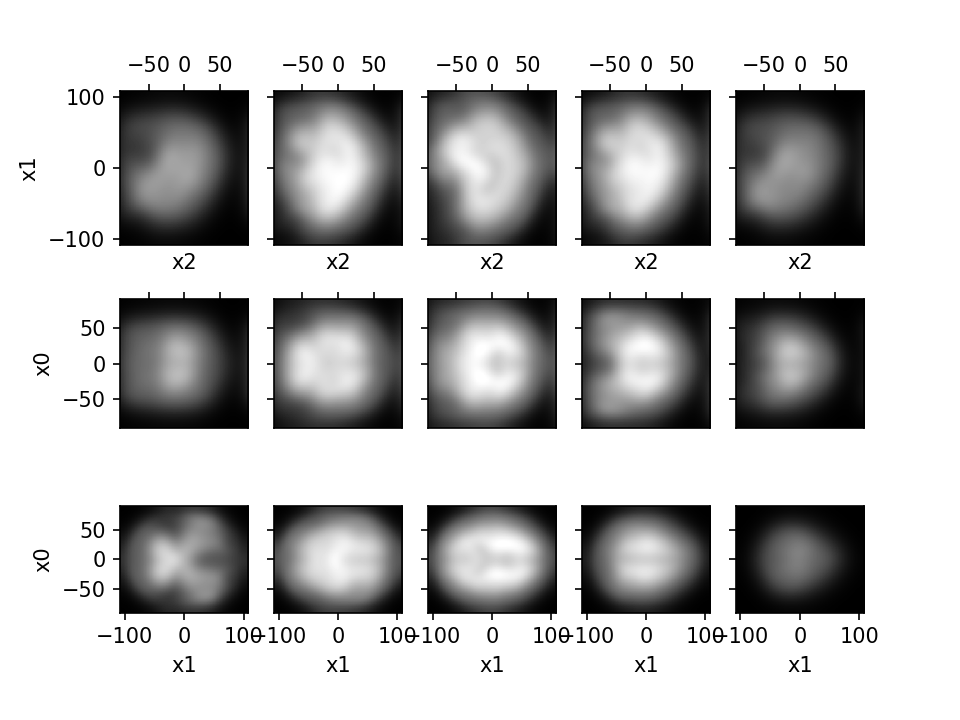

In [7]:
# build a smoothing kernel in the Fourier domain
p = 2
a = dx[0]*5
f0 = np.arange(nx[0])/dx[0]/nx[0]
f1 = np.arange(nx[1])/dx[1]/nx[1]
f2 = np.arange(nx[2])/dx[2]/nx[2]
F0,F1,F2 = np.meshgrid(f0, f1, f2, indexing='ij')
# identity minus laplacian, in fourier domain
# AI[i,j] = I[i,j] - alpha^2( (I[i+1,j] - 2I[i,j] + I[i-1,j])/dx^2 + (I[i,j+1] - 2I[i,j] + I[i,j-1])/dy^2  )
Lhat = (1.0 - a**2*( (-2.0 + 2.0*np.cos(2.0*np.pi*dx[0]*F0))/dx[0]**2 
    + (-2.0 + 2.0*np.cos(2.0*np.pi*dx[1]*F1))/dx[1]**2
    + (-2.0 + 2.0*np.cos(2.0*np.pi*dx[2]*F2))/dx[2]**2 ) )**p
LLhat = Lhat**2
Khat = 1.0/LLhat

# apply it to our image
Itf = tf.constant(I,dtype=lddmm.dtype)
with tf.Session() as sess:
    Ismooth = tf.real(tf.ifft3d(tf.fft3d(tf.complex(Itf, 0.0)) * Khat ))
    Ismoothnp = Ismooth.eval()
f = plt.figure()        
vis.imshow_slices(Ismoothnp,x=x,fig=f)
f.canvas.draw()